# Image tracking tutorial with Dask

## Demo data

We use data from the [Cell Tracking Challenge](http://celltrackingchallenge.net/3d-datasets/),
specifically:

- the [C. elegans developing embryo training
  dataset](http://data.celltrackingchallenge.net/training-datasets/Fluo-N3DH-CE.zip)
  (3GB), **OR**, if that is too large for you to comfortably download,
- the [Chinese Hamster Ovarian (CHO) nuclei overexpressing GFP-PCNA training
  dataset](http://data.celltrackingchallenge.net/training-datasets/Fluo-N3DH-CHO.zip)
  (98MB)

## dask.distributed

A first life hack: in general, avoid using bare dask, and instead create a `dask.distributed` Client as in the cell below. What this buys you:

- a [diagnostics dashboard](https://docs.dask.org/en/latest/diagnostics-distributed.html). This can be invaluable in helping to understand performance in your application. We'll see a live example below.
- seamless scaling. Whether the scheduler is using local workers or connected to [your institution's HPC](https://jobqueue.dask.org/en/latest/), or [cloud compute](https://docs.dask.org/en/latest/setup/cloud.html), the API is the same — you just change the scheduler and connect the Client to it.

Learn more about the dask dashboard with:
- This introduction to the dask dashboard (20 minute video): https://www.youtube.com/watch?v=N_GqzcuGLCY
- This introduction to the jupyterlab extension (5 minute video): https://www.youtube.com/watch?v=EX_voquHdk0

In [1]:
from dask import distributed
client = distributed.Client()
print(client.dashboard_link)

http://127.0.0.1:8787/status


## Load the image data

As mentioned at the top of this notebook, we will use data from the [Cell Tracking Challenge](http://celltrackingchallenge.net/3d-datasets/),
specifically:

- the [C. elegans developing embryo training
  dataset](http://data.celltrackingchallenge.net/training-datasets/Fluo-N3DH-CE.zip)
  (3GB), **OR**, if that is too large for you to comfortably download,
- the [Chinese Hamster Ovarian (CHO) nuclei overexpressing GFP-PCNA training
  dataset](http://data.celltrackingchallenge.net/training-datasets/Fluo-N3DH-CHO.zip)
  (98MB)


In [2]:
from dask_image.imread import imread

In [7]:
# Please set the path to your data here!
ROOT_PATH = '/home/.../data/Fluo-N3DH-CHO/'


In [8]:
# note you might need a slight downsample here to deal with a known ghosting issue
embryo = imread(ROOT_PATH + '01/t*.tif')[:, :, ::2, ::2]

In [9]:
type(embryo)

dask.array.core.Array

In [10]:
embryo.shape

(92, 5, 222, 256)

In [11]:
embryo.dtype

dtype('uint8')

In [12]:
embryo.nbytes / 1e9

0.02614272

In [13]:
embryo.chunksize

(1, 5, 222, 256)

In [1]:
import napari
from napari.utils import nbscreenshot

viewer = napari.view_image(embryo, scale=[1, 5, 1, 1])

nbscreenshot(viewer)

### <span style="color:cornflowerblue">Exercise: file formats</span>

Open the dask dashboard, and view it while changing timepoints in napari. How long does loading a tiff file take?

If you have enough room in your drive, the [zarr](https://zarr.readthedocs.io/en/stable/) format offers much faster read from disk than tiff, especially for segmentations, which have very effective compression.

Use `dask.Array.to_zarr` to save to a zarr file, and reload the array with `dask.array.from_zarr`. Swap out the image layer for the zarr-based one. How long does the load take now?

In [7]:
# Solution

## Adding the tracking data

Now, let's view the tracking data. The track format is described in [this pdf](https://public.celltrackingchallenge.net/documents/Naming%20and%20file%20content%20conventions.pdf). You can also see a description of the below workflow without dask (ie it *must* fit in your RAM) at [this napari documentation page](https://napari.org/tutorials/applications/cell_tracking).

The tracklets are actually individually-labelled pixels within a volume like the original image. napari prefers to display tracks directly from coordinates, so we will use dask to convert from one to the other.

We are lucky: the images can be processed one at a time (which dask is perfect for), and the compressed data (just point coordinates) are much, much smaller — easy to fit in RAM. We take advantage of this in the below workflow.

In [16]:
tracklet_images = imread(ROOT_PATH + '01_GT/TRA/man_track*.tif')[:, : , ::2, ::2]

First, we define a function that will work on an individual volume, together with that volume's index (ie the timepoint).

In [17]:
from skimage.measure import regionprops_table
import pandas as pd


def image_to_tracklets(volume, idx):
    props_dict = regionprops_table(
        np.asarray(volume), properties=('label', 'centroid')
    )
    props_df = pd.DataFrame(props_dict)
    props_df['frame'] = idx
    return props_df[
        ['label', 'frame', 'centroid-0', 'centroid-1', 'centroid-2']
    ]

Now we can run that function on the whole volume using the `Client.map` API. Futures are little IOUs for computation: a Future may or may not contain the result of the computation. Calling `future.result()` on a Future object causes Python to wait for that result to be ready. Otherwise, creating a Future is more or less instantaneous.

We will see later that futures have a `.cancel()` method — useful when you trigger a lot of computation but realise you want to stop it!

In [19]:
import numpy as np

futures = client.map(
    image_to_tracklets,
    tracklet_images,
    np.arange(len(tracklet_images)),
)

In [20]:
all_tables = [f.result() for f in futures]

In [21]:
tracklets = (
    pd.concat(all_tables)
    .reset_index(drop=True)
    .sort_values(['label', 'frame'])
)

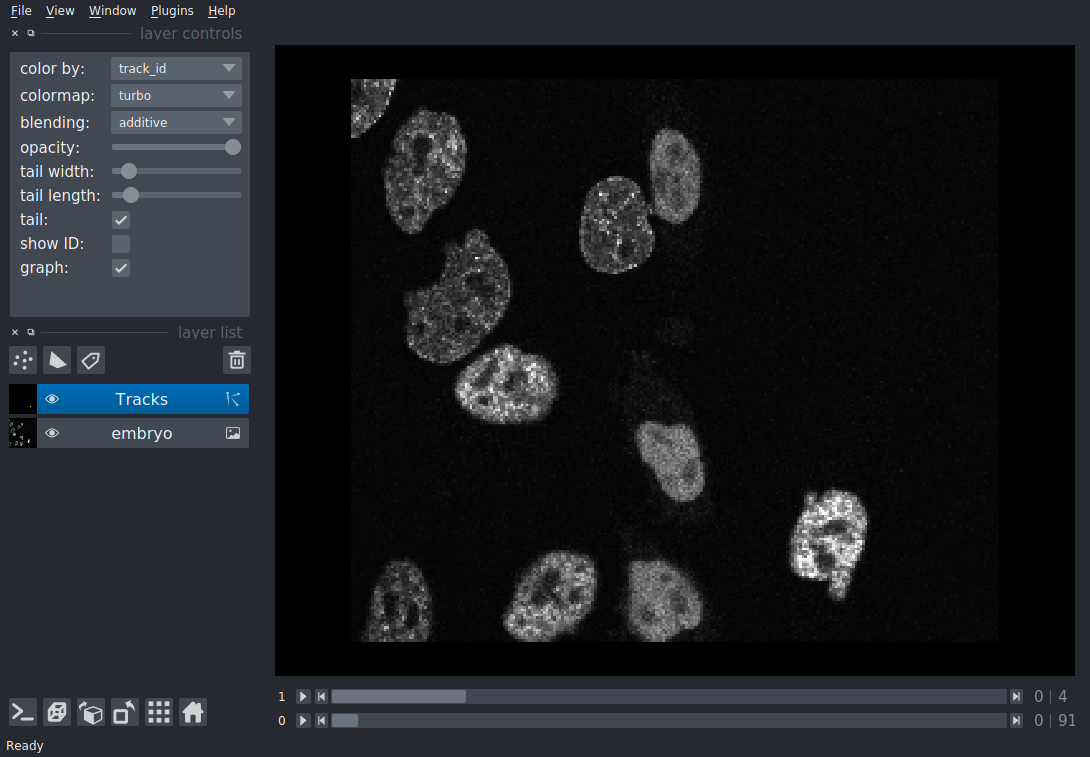

In [22]:
tracklets_layer = viewer.add_tracks(tracklets, scale=[1, 5, 1, 1])

nbscreenshot(viewer)

We want to also load the lineage information, which is presented in a table called `man_track.txt`, containing the following four columns, called LBEP:

> - L - a unique label of the track (label of markers, 16-bit positive value)
> - B - a zero-based temporal index of the frame in which the track begins
> - E - a zero-based temporal index of the frame in which the track ends
> - P - label of the parent track (0 is used when no parent is defined)


In [23]:
lbep = np.loadtxt(
    ROOT_PATH + '01_GT/TRA/man_track.txt',
    dtype=np.uint,
)

In [24]:
full_graph = dict(lbep[:, [0, 3]])
graph = {k: v for k, v in full_graph.items() if v != 0}

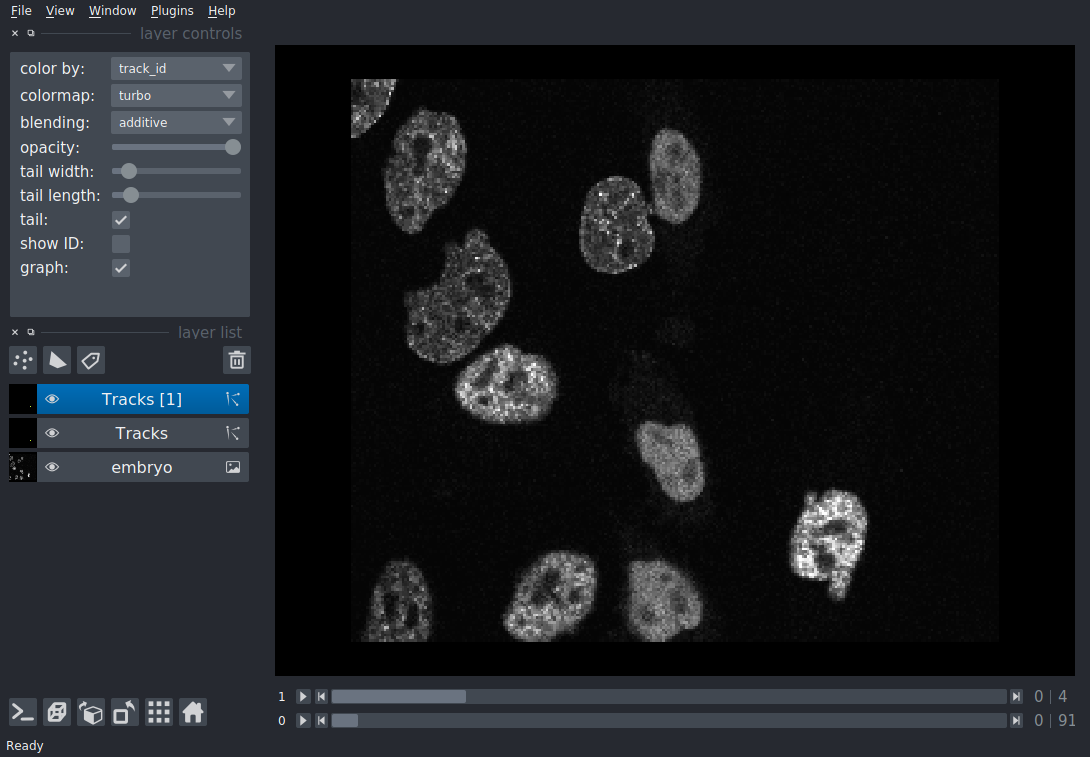

In [25]:
tracks_layer = viewer.add_tracks(tracklets, graph=graph, scale=[1, 5, 1, 1])

nbscreenshot(viewer)

## Challenge

Our final goal will be to compute a segmentation from the grayscale image together with the points in the tracks. Just like last time, we will use smoothed and thresholded nuclei as a mask, and we will use the track points (conveniently already in marker image format!) to run watershed on each.

We can use the `dask-image` library, which contains many functions adapted from `scipy.ndimage`, to do the smoothing:

In [26]:
from dask_image import ndfilters

smoothed = ndfilters.gaussian_filter(
    embryo,
    sigma=[0, 1, 5, 5],
)

smoothed_layer = viewer.add_image(
    smoothed,
    scale=[5, 1, 1],
)

And we can use [`dask.array.map_blocks`](https://docs.dask.org/en/latest/array-api.html#dask.array.map_blocks) to find the edges of the nuclei, just like in the previous notebook:

In [28]:
import dask.array as da
from skimage import filters

edges = da.map_blocks(filters.scharr, smoothed)

edges_layer = viewer.add_image(edges, scale=[5, 1, 1])

### <span style="color:cornflowerblue">Final challenge: distributed segmentation with dask</span>

1. Find threshold values for each timepoint of the smoothed data using `client.map` and a scikit-image thresholding function from `skimage.filters`. Create an array of the thresholding values
2. Using [NumPy broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html), produce a Dask array containing the thresholded smooth values. Add this array to napari.
3. (Optionally) use [`da.map_blocks`](https://docs.dask.org/en/latest/array-api.html#dask.array.map_blocks) with a custom filter function to find better boundaries of the nuclei. Add this array to napari.
4. Use [`da.map_blocks`](https://docs.dask.org/en/latest/array-api.html#dask.array.map_blocks) together with `skimage.segmentation.watershed` and the three previous arrays to create the output segmentation. Add this array as label layer to napari.
5. Navigate the volume by clicking on the slider, and monitor the Dask dashboard. (Tip: to reduce lag in response time, toggle the visibility OFF for any layers you are not looking at in napari).

In [29]:
# Solution